# Equi Boots Graphical Notebook

## Library Imports

In [1]:
import pandas as pd
import numpy as np
import os
import sys

# Add path to import EquiBoots
script_path = os.path.abspath("../py_scripts")
print("Appending path:", script_path)
sys.path.append(script_path)

Appending path: /home/lshpaner/Documents/GitHub_Repositories/equi_boots/py_scripts


In [2]:
import equiboots as eqb

## Prepping `equiboots`

### Classification Mock-Up

The code below generates synthetic classification data and prepares it for group-based fairness analysis using `equiboots`. It includes:

- Simulated predictions and ground truth labels  
- Demographic group features (race and sex)  
- Construction of a fairness_df with group attributes  
- Initialization of the `EquiBoots` object for slicing and grouping data  

In [3]:
# Generate synthetic test data
y_prob = np.random.rand(1000)
y_pred = y_prob > 0.5
y_true = np.random.randint(0, 2, 1000)

race = (
    np.random.RandomState(3)
    .choice(["white", "black", "asian", "hispanic"], 1000)
    .reshape(-1, 1)
)
sex = np.random.choice(["M", "F"], 1000).reshape(-1, 1)

fairness_df = pd.DataFrame(
    data=np.concatenate((race, sex), axis=1), columns=["race", "sex"]
)

# Initialize and process groups
eq = eqb.EquiBoots(
    y_true=y_true,
    y_prob=y_prob,
    y_pred=y_pred,
    fairness_df=fairness_df,
    fairness_vars=["race", "sex"],
)
eq.grouper(groupings_vars=["race", "sex"])
sliced_data = eq.slicer("race")

Groups created


## ROC AUC

### Overlay ROC AUC

The cells below generates an overlayed ROC curve visualization for different race groups using the `eq_plot_group_curves` function. It helps assess model performance disparities across demographic subgroups by comparing their respective ROC curves. 

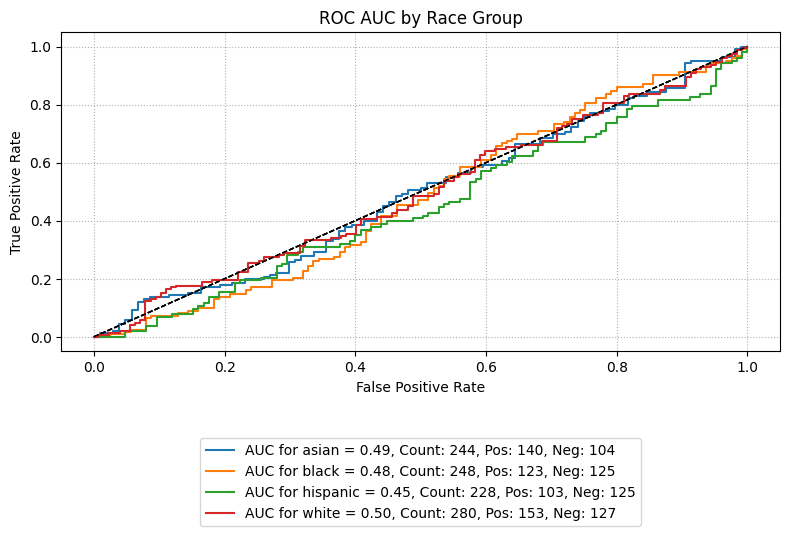

In [4]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="roc",
    # filename="bla",
    title="ROC AUC by Race Group",
    n_bins=10,
    # group="black",
    # exclude_groups=["black", "asian"],
    save_path="./images",
)

### Subplots

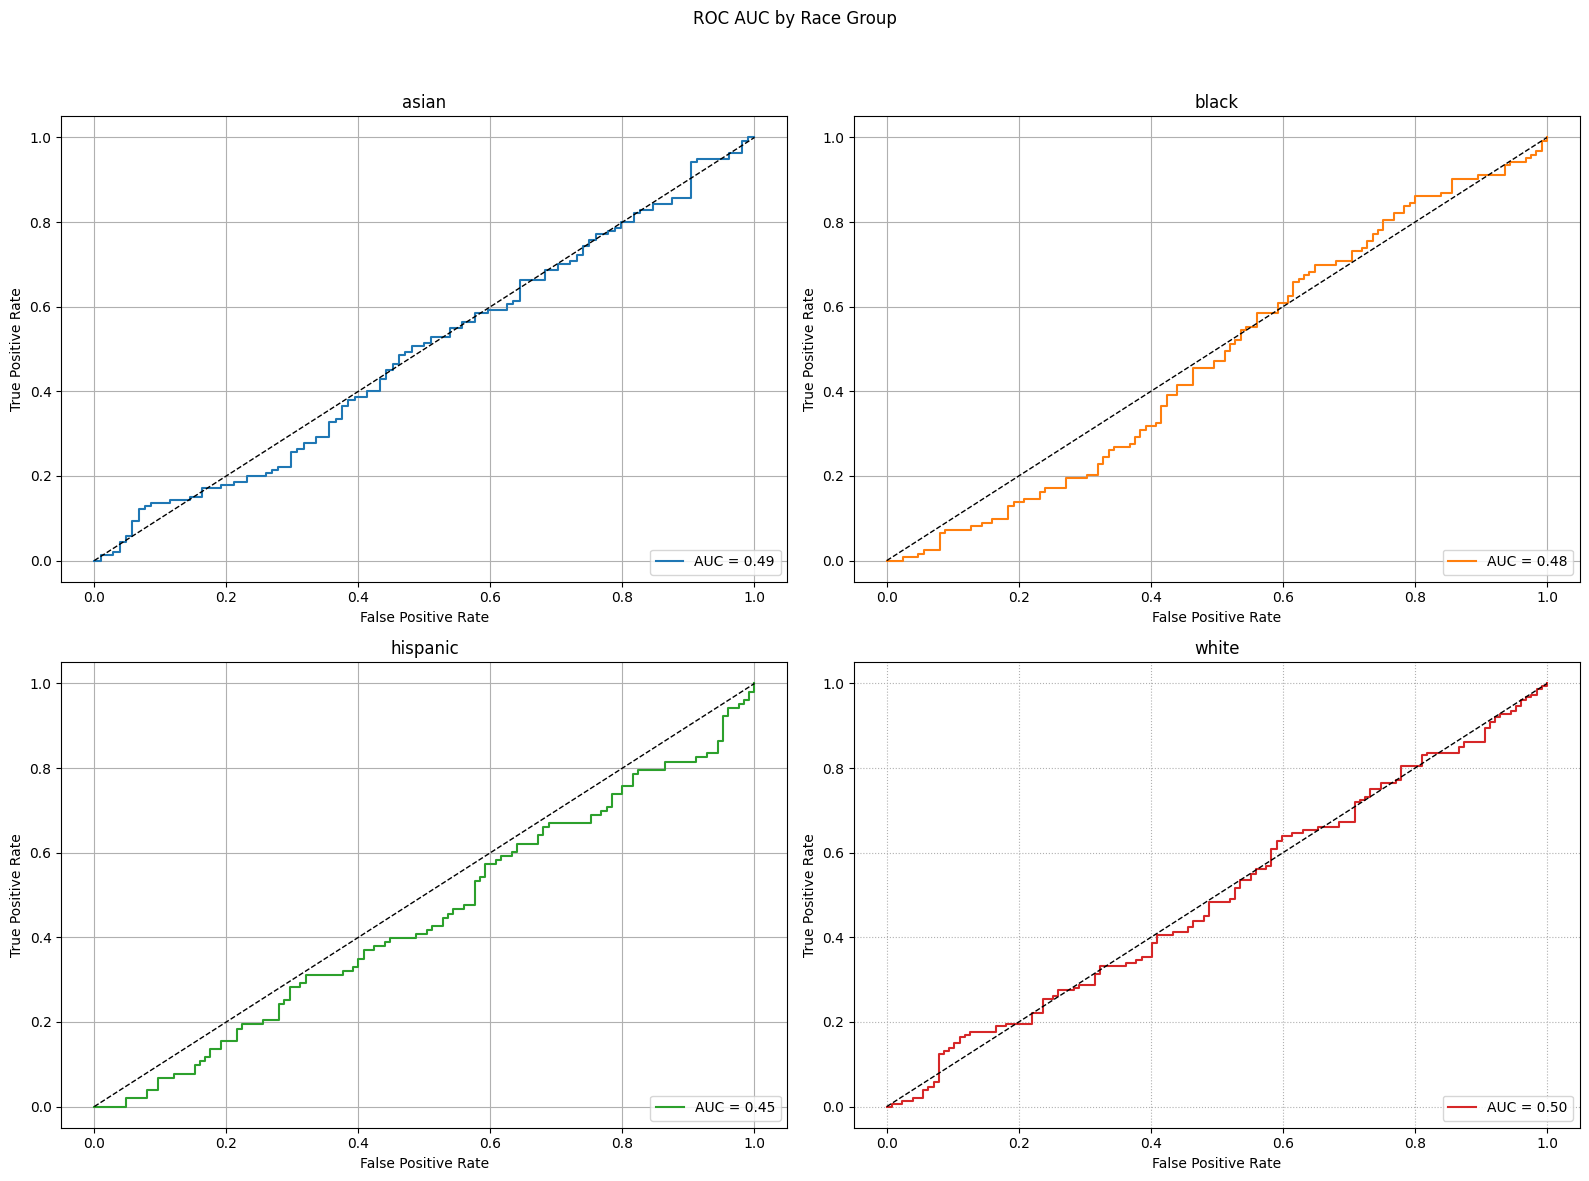

In [5]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="roc",
    title="ROC AUC by Race Group",
    # figsize=(5, 5),
    decimal_places=2,
    subplots=True,
)

### Example of Single Race Group

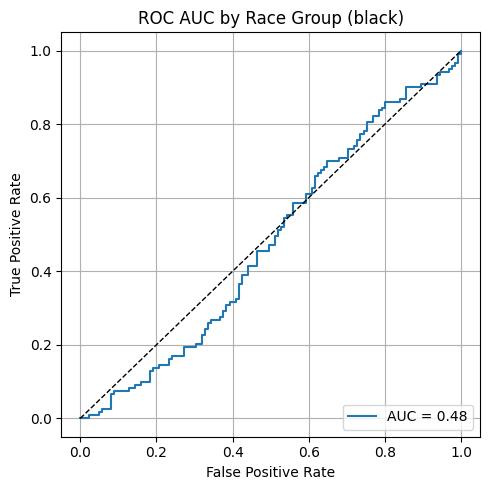

In [6]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="roc",
    title="ROC AUC by Race Group",
    figsize=(5, 5),
    group="black",
    color_by_group=False,
)

## Precision-Recall Curves

### Overlay Precision-Recall Curves

The cells below generates an overlayed ROC curve visualization for different race groups using the `eq_plot_group_curves` function. It helps assess model performance disparities across demographic subgroups by comparing their respective ROC curves. 

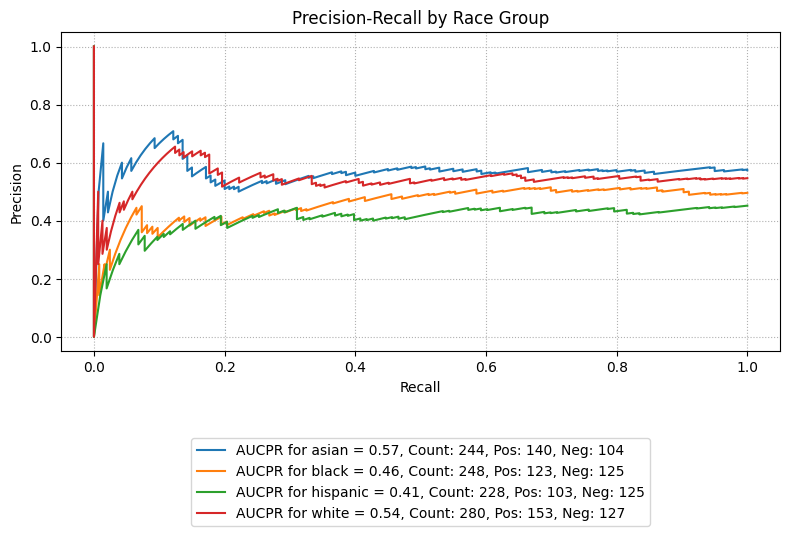

In [7]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="pr",
    title="Precision-Recall by Race Group",
)

### Subplots

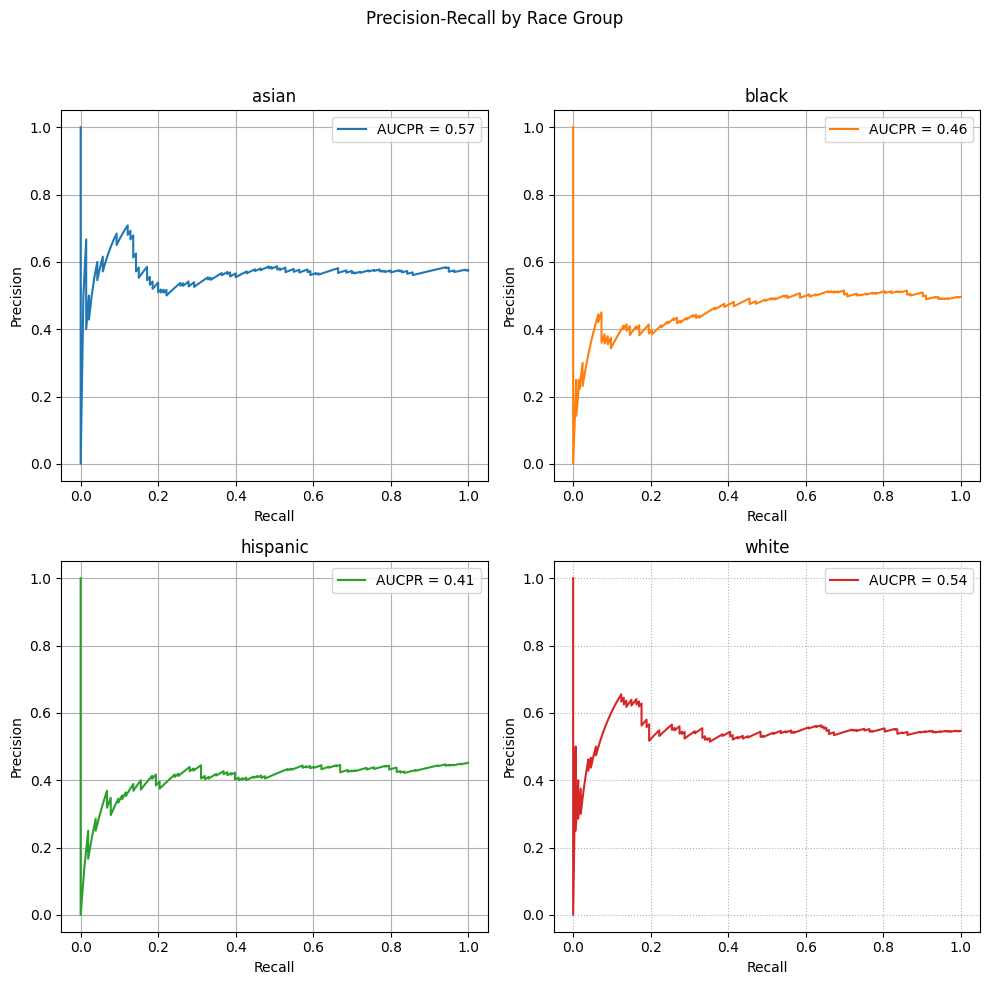

In [8]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="pr",
    title="Precision-Recall by Race Group",
    filename="race",
    figsize=(5, 5),
    decimal_places=2,
    n_cols=2,
    # show_grid=False,
    subplots=True,
)

### Example of Single Race Group

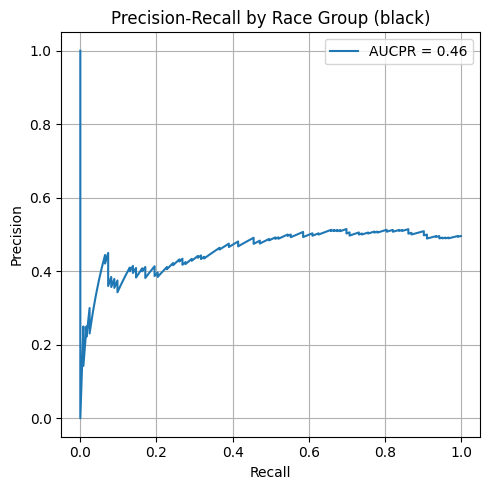

In [9]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="pr",
    title="Precision-Recall by Race Group",
    figsize=(5, 5),
    group="black",
    color_by_group=False,
)

## Calibration Plot

### Overlay

The following cell generates calibration curves for each race group to visualize how well predicted probabilities align with actual outcomes. Using the `eq_plot_group_curves` function in overlay mode. This is a useful diagnostic for evaluating model reliability and potential miscalibration across demographic subgroups.

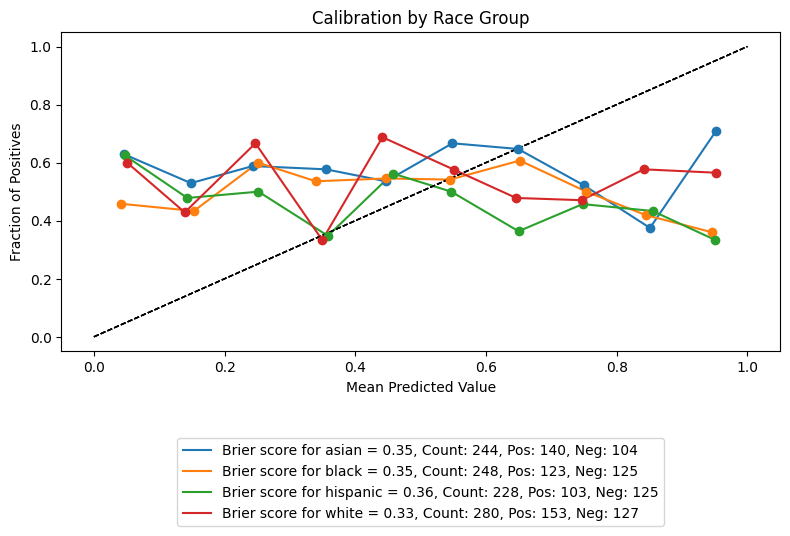

In [10]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="calibration",
    title="Calibration by Race Group",
    n_bins=10,
    show_grid=False,
    # exclude_groups="white",
)

### Subplots

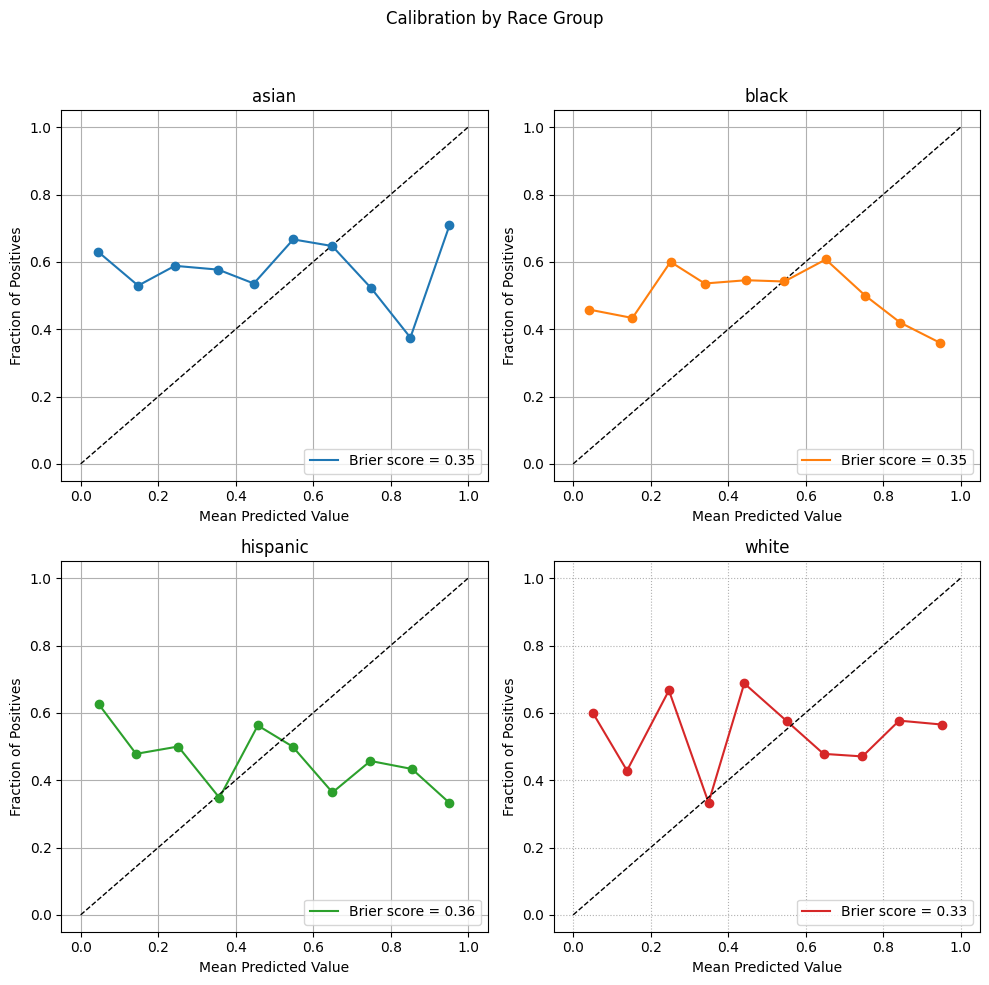

In [11]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="calibration",
    title="Calibration by Race Group",
    figsize=(5, 5),
    decimal_places=2,
    subplots=True,
)

### Example of Single Race Group

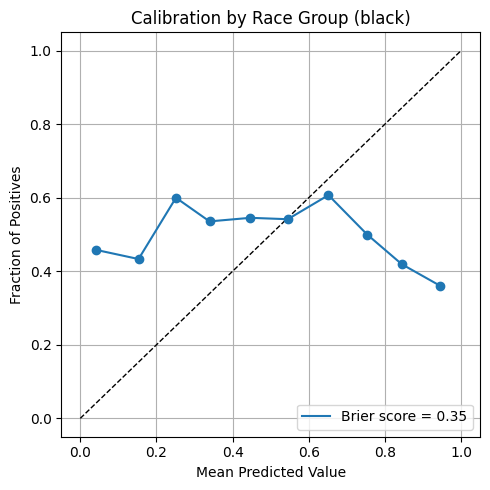

In [12]:
eqb.eq_plot_group_curves(
    sliced_data,
    curve_type="calibration",
    title="Calibration by Race Group",
    figsize=(5, 5),
    group="black",
    color_by_group=False,
)

## Bootstrap Graphs

This section sets up the `EquiBoots` class to compute fairness disparities across race and sex groups using both bootstrapped and non-bootstrapped strategies. Key elements include:

- Initialization of the `EquiBoots` object with bootstrapping enabled (`bootstrap_flag=True`)
- Seeding for reproducibility across 10 boot iterations
- Grouping and slicing by demographic variables
- Metric computation and disparity calculation per group (e.g., race)
- Final output prepared in a long-form DataFrame for visualization



In [13]:
eq2 = eqb.EquiBoots(
    y_true,
    y_prob,
    y_pred,
    fairness_df,
    fairness_vars=["race", "sex"],
    reference_groups=["white", "M"],
    task="binary_classification",
    bootstrap_flag=True,
    num_bootstraps=10,
    boot_sample_size=100,
    balanced=False,  # False is stratified, True is balanced
    # stratify_by_outcome=True,
)

# Set seeds
int_list = np.linspace(0, 100, num=10, dtype=int).tolist()
eq2.set_fix_seeds(int_list)
print("seeds", eq2.seeds)

eq2.grouper(groupings_vars=["race", "sex"])

data = eq2.slicer("race")
race_metrics = eq2.get_metrics(data)
dispa = eq2.calculate_disparities(race_metrics, "race")

melted = pd.DataFrame(dispa).melt()
df = melted["value"].apply(pd.Series).assign(attribute_value=melted["variable"])
sliced = eq2.slicer(slicing_var="race")

seeds [0, 11, 22, 33, 44, 55, 66, 77, 88, 100]


Bootstrapping iterations: 100%|██████████| 10/10 [00:00<00:00, 567.05it/s]

Groups created


#### Bootstrapped Disparities (and General Metrics (Non-Disparity)) (Pass/Fail)

The following violinplots show the disparity metrics within threshold for what they are. In the ensuing cell, we will show them for each group as pass or fail.

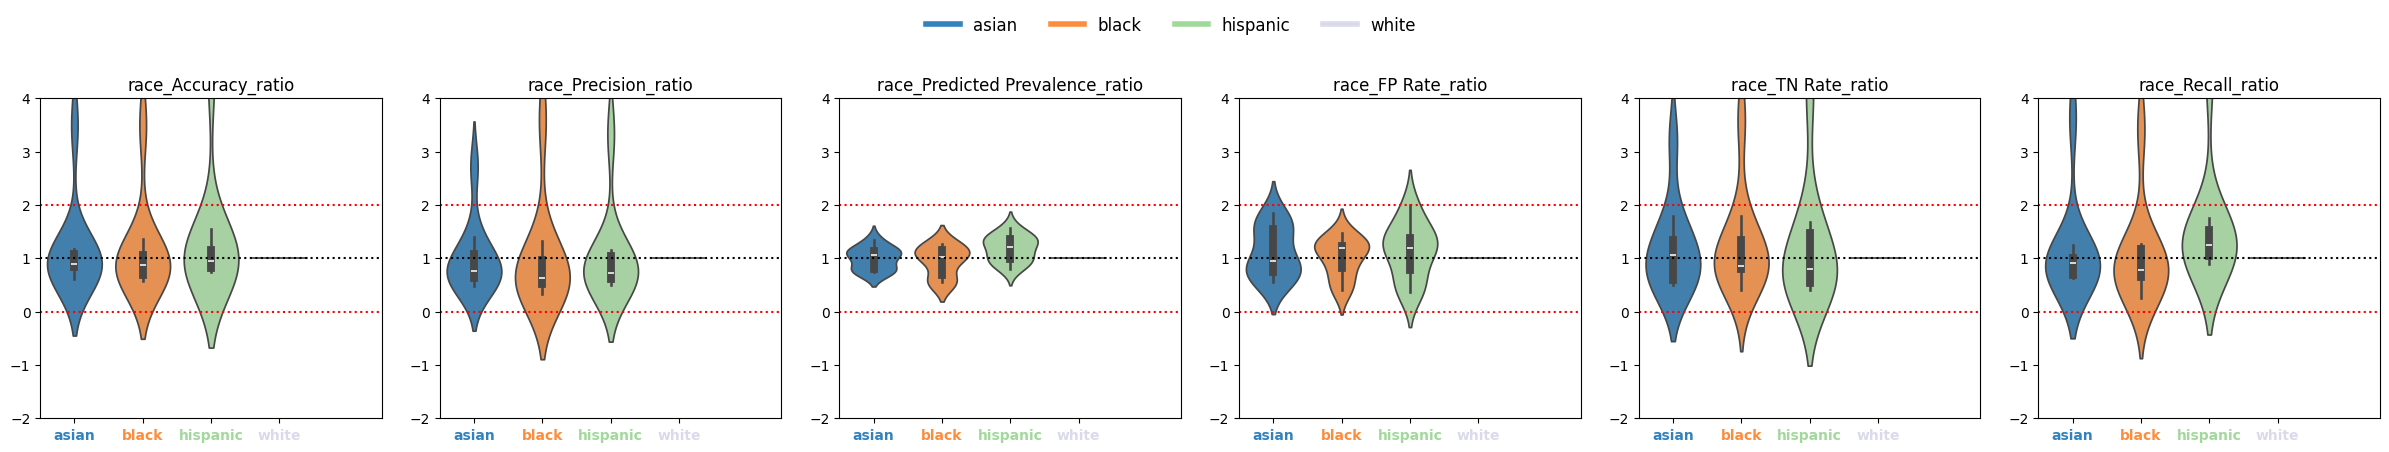

In [14]:
eqb.eq_group_metrics_snsplot(
    group_metrics=dispa,
    metric_cols=[
        "Accuracy_ratio",
        "Precision_ratio",
        "Predicted Prevalence_ratio",
        "FP Rate_ratio",
        "TN Rate_ratio",
        "Recall_ratio",
    ],
    name="race",
    categories="all",
    figsize=(24, 4),
    plot_kind="violinplot",
    color_by_group=True,
    show_grid=False,
    strict_layout=True,
    save_path="./images",
    # show_pass_fail=True,
    # y_lim=(-2, 4),
    # disparity_thresholds=[0.9, 1.2],
)

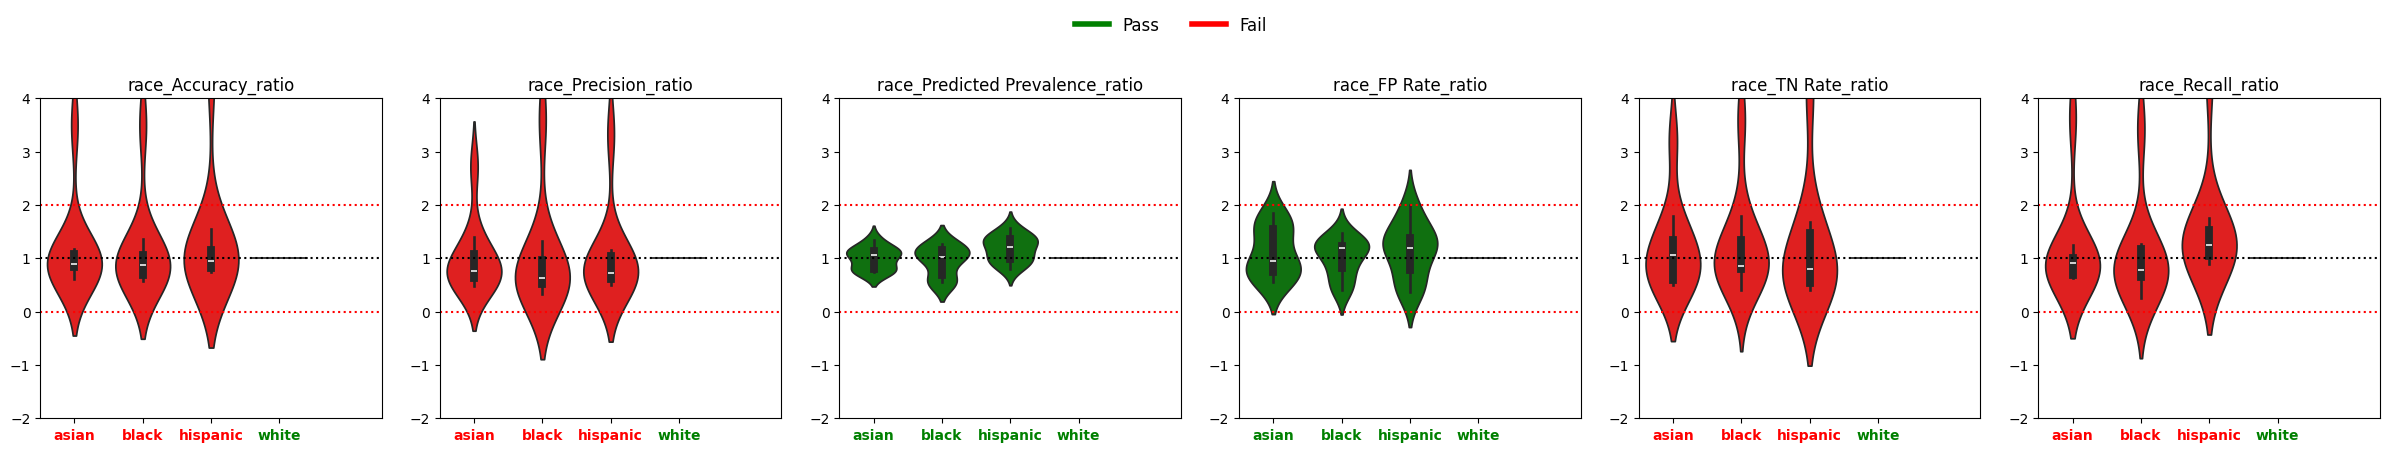

In [15]:
eqb.eq_group_metrics_snsplot(
    group_metrics=dispa,
    metric_cols=[
        "Accuracy_ratio",
        "Precision_ratio",
        "Predicted Prevalence_ratio",
        "FP Rate_ratio",
        "TN Rate_ratio",
        "Recall_ratio",
    ],
    name="race",
    categories="all",
    figsize=(24, 4),
    plot_kind="violinplot",
    color_by_group=True,
    show_grid=False,
    strict_layout=True,
    save_path="./images",
    show_pass_fail=True,
    # y_lim=(-2, 4),
    # disparity_thresholds=[0.9, 1.2],
)

Below we define new variables using the EquiBoots class to calculate disparities and non-disparity metrics
for race and sex groups such that they can be used in the point estimates plot.

In [16]:
eq3 = eqb.EquiBoots(
    y_true,
    y_prob,
    y_pred,
    fairness_df,
    fairness_vars=["race", "sex"],
    reference_groups=["white", "M"],
    task="binary_classification",
    bootstrap_flag=False,
)

eq3.grouper(groupings_vars=["race", "sex"])
sliced_data = eq3.slicer("race")

data_race = eq3.slicer("race")
data_sex = eq3.slicer("sex")

race_metrics_3 = eq3.get_metrics(data_race)
sex_metrics_3 = eq3.get_metrics(data_sex)

dispa_race = eq3.calculate_disparities(race_metrics_3, "race")
dispa_sex = eq3.calculate_disparities(sex_metrics_3, "sex")

Groups created


#### Point Estimate Disparities and General (Non-Disparity) Metrics (Pass/Fail)

The following violinplots show the disparity metrics within threshold for what they are. In the ensuing cell, we will show them for each group as pass or fail.m

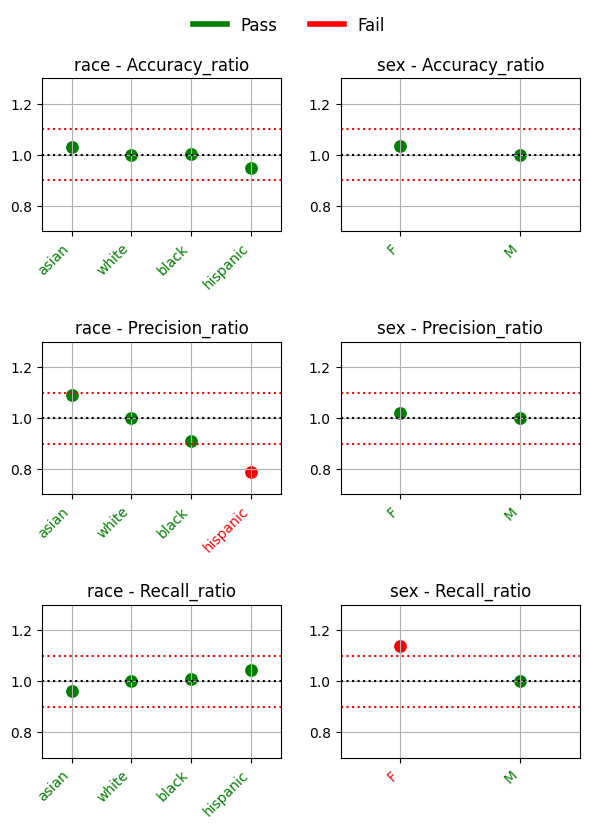

In [17]:
# Run with custom y_lim and adjusted thresholds
eqb.eq_group_metrics_point_plot(
    group_metrics=[dispa_race, dispa_sex],
    metric_cols=[
        "Accuracy_ratio",
        "Precision_ratio",
        "Recall_ratio",
    ],
    category_names=["race", "sex"],
    figsize=(6, 8),
    include_legend=True,
    plot_thresholds=(0.9, 1.1),
    show_pass_fail=True,
    # raw_metrics=False,
    show_grid=True,
    y_lim=(0.7, 1.3),
    # y_lim=(0, 0.9),
)

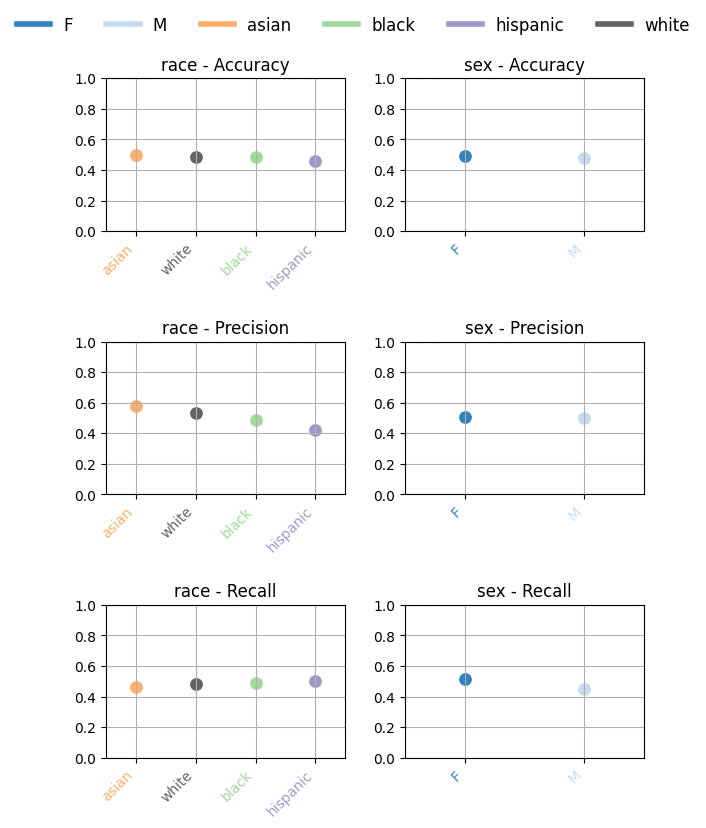

In [18]:
# Run with custom y_lim and adjusted thresholds
eqb.eq_group_metrics_point_plot(
    group_metrics=[race_metrics_3, sex_metrics_3],
    metric_cols=[
        "Accuracy",
        "Precision",
        "Recall",
    ],
    category_names=["race", "sex"],
    figsize=(6, 8),
    include_legend=True,
    plot_thresholds=(0.9, 1.1),
    show_pass_fail=True,
    raw_metrics=True,
    show_grid=True,
    y_lim=(0, 1),
)

### ROCAUC Bootstrap

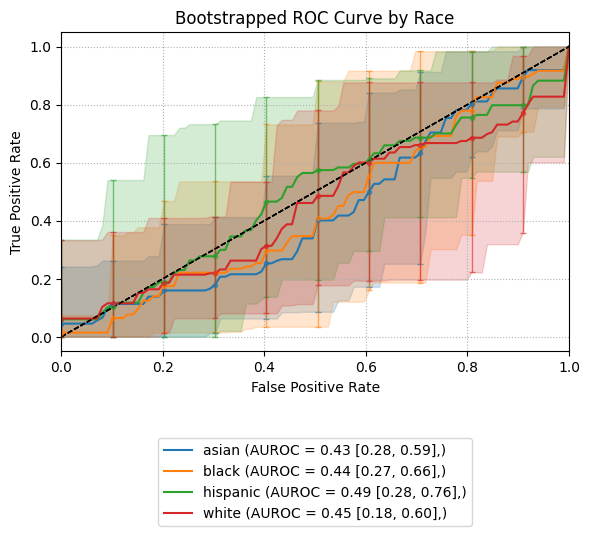

In [19]:
eqb.eq_plot_bootstrapped_group_curves(
    boot_sliced_data=sliced,
    curve_type="roc",
    title="Bootstrapped ROC Curve by Race",
    filename="boot_roc_race",
    # bar_every=100,
    dpi=100,
    n_bins=10,
    figsize=(6, 6),
    color_by_group=True,
)

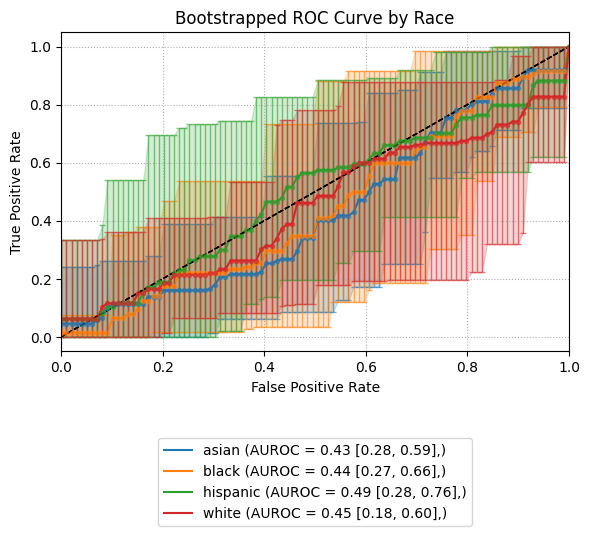

In [20]:
eqb.eq_plot_bootstrapped_group_curves(
    boot_sliced_data=sliced,
    curve_type="roc",
    title="Bootstrapped ROC Curve by Race",
    filename="boot_roc_race",
    save_path="./images",
    # subplots=True,
    bar_every=100,
    dpi=100,
    n_bins=10,
    figsize=(6, 6),
    color_by_group=True,
)

### Precision-Recall Bootstrap

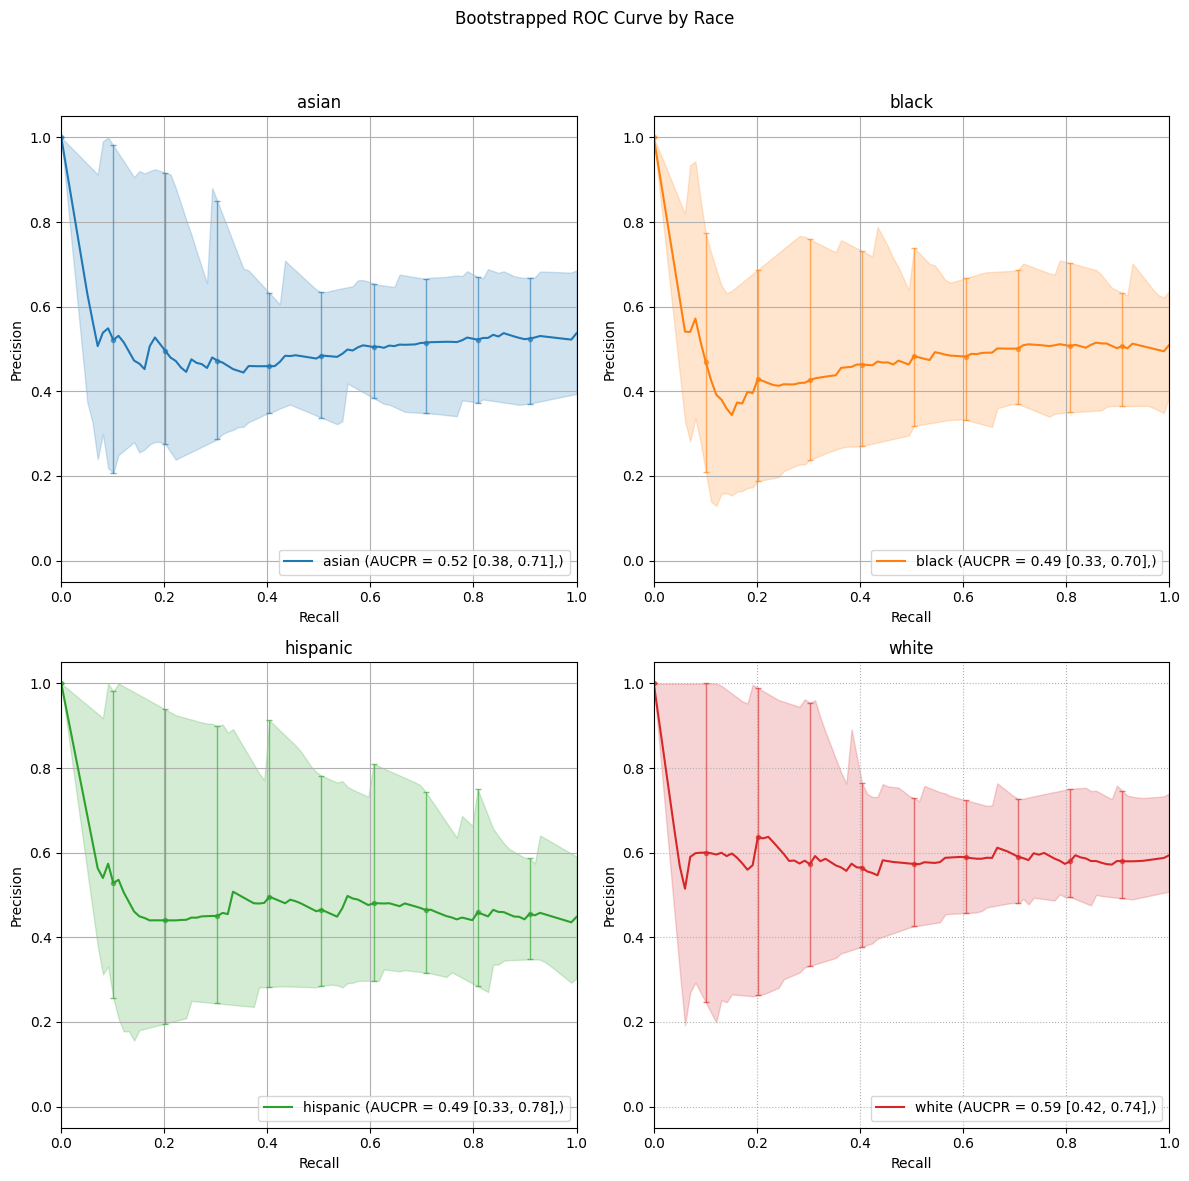

In [21]:
eqb.eq_plot_bootstrapped_group_curves(
    boot_sliced_data=sliced,
    curve_type="pr",
    title="Bootstrapped ROC Curve by Race",
    figsize=(6, 6),
    color_by_group=True,
    subplots=True,
    # exclude_groups=247,
)

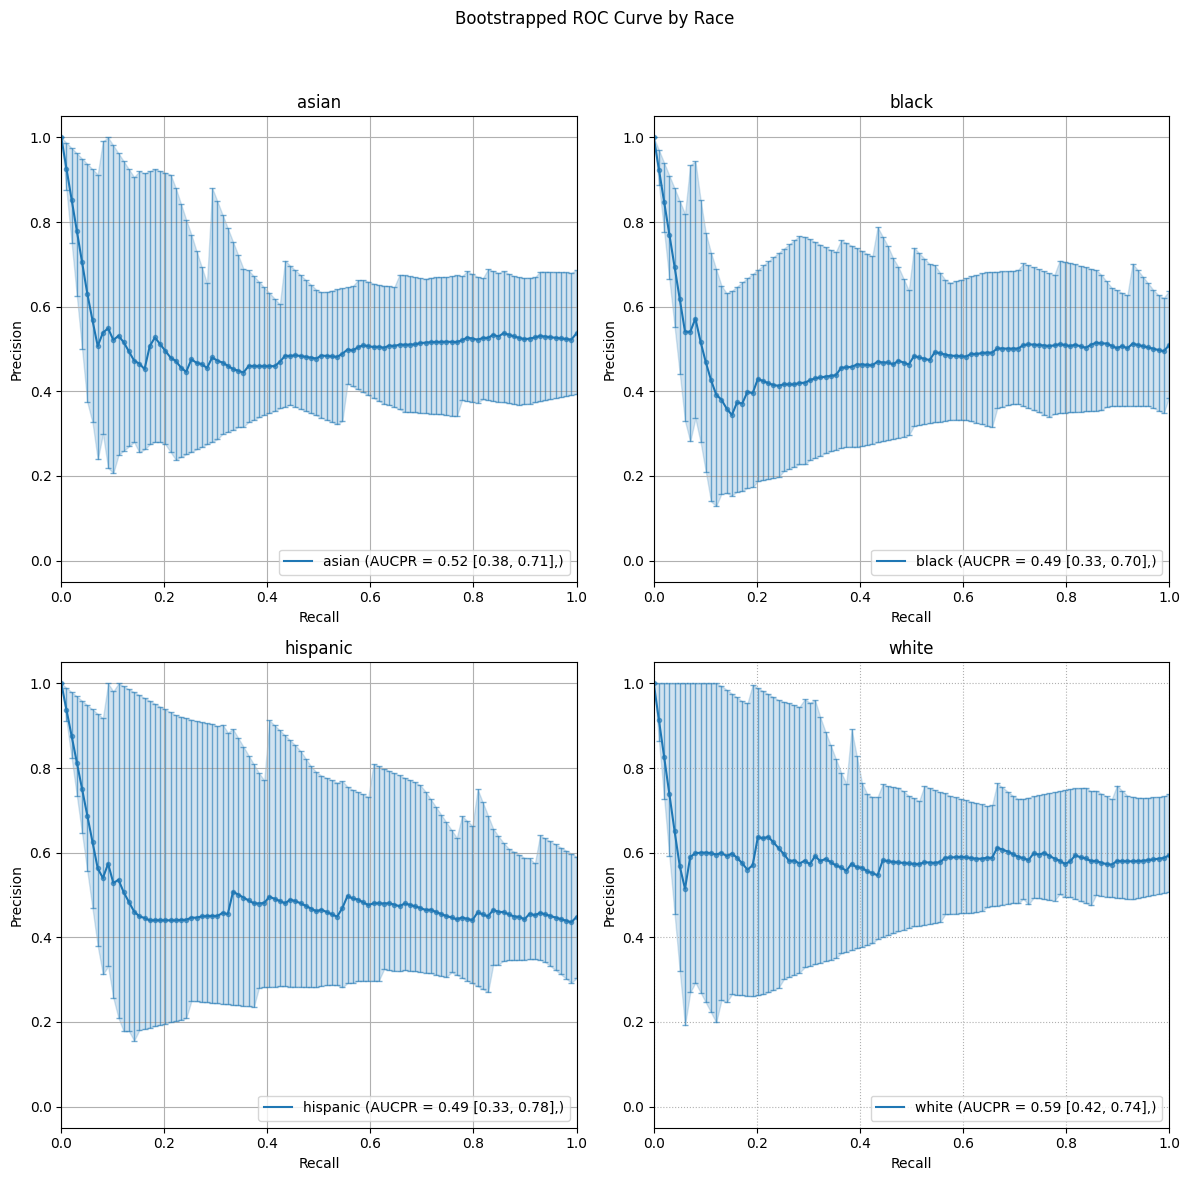

In [22]:
eqb.eq_plot_bootstrapped_group_curves(
    boot_sliced_data=sliced,
    curve_type="pr",
    title="Bootstrapped ROC Curve by Race",
    subplots=True,
    bar_every=100,
    figsize=(6, 6),
    color_by_group=False,
    exclude_groups=555,
)

### Calibration Plots Bootstrapped

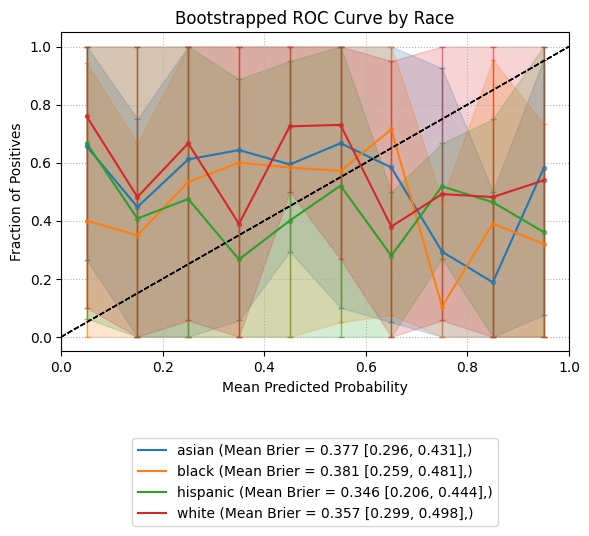

In [23]:
eqb.eq_plot_bootstrapped_group_curves(
    boot_sliced_data=sliced,
    curve_type="calibration",
    title="Bootstrapped ROC Curve by Race",
    figsize=(6, 6),
    color_by_group=True,
)

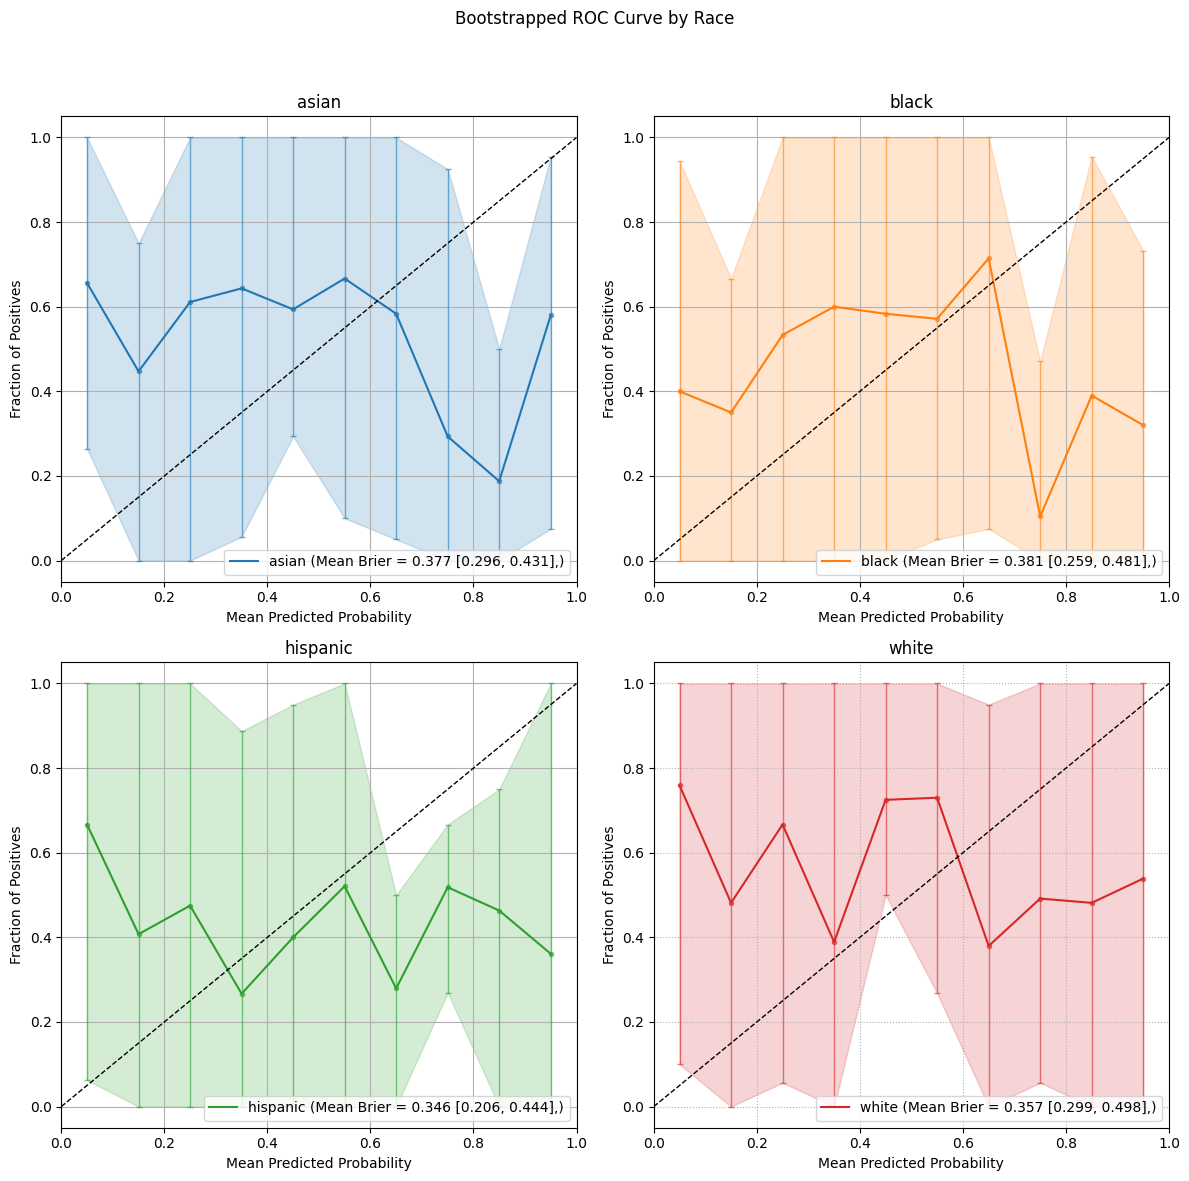

In [24]:
eqb.eq_plot_bootstrapped_group_curves(
    boot_sliced_data=sliced,
    curve_type="calibration",
    title="Bootstrapped ROC Curve by Race",
    figsize=(6, 6),
    subplots=True,
    color_by_group=True,
)

## Regression Mock-Up

In [25]:
## Generate synthetic regression-like data
np.random.seed(42)
y_true = np.random.normal(loc=50, scale=10, size=1000)  ## continuous target
y_pred = y_true + np.random.normal(
    loc=0, scale=5, size=1000
)  # predicted value with noise

# Not really 'prob', but using this slot for predicted values
y_prob = y_pred

race = (
    np.random.RandomState(3)
    .choice(["white", "black", "asian", "hispanic"], 1000)
    .reshape(-1, 1)
)
sex = np.random.choice(["M", "F"], 1000).reshape(-1, 1)

fairness_df = pd.DataFrame(
    data=np.concatenate((race, sex), axis=1), columns=["race", "sex"]
)

# Initialize and process groups
eq3 = eqb.EquiBoots(
    y_true=y_true,
    y_prob=y_prob,
    y_pred=y_pred,
    task="regression",
    fairness_df=fairness_df,
    fairness_vars=["race", "sex"],
)
eq3.grouper(groupings_vars=["race", "sex"])
sliced_data_2 = eq3.slicer("race")

Groups created


## Regression Residuals

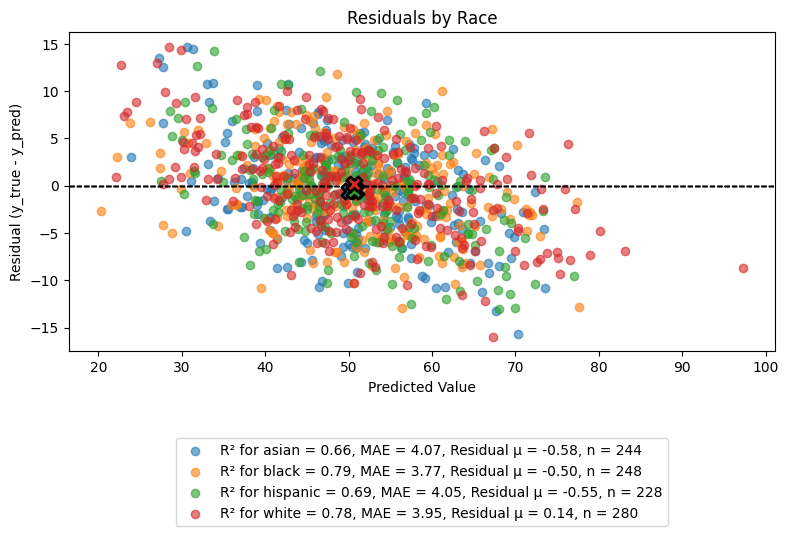

In [26]:
eqb.eq_plot_residuals_by_group(
    data=sliced_data_2,
    # y_true=y_true,
    # y_prob=y_pred,
    # group="black",
    title="Residuals by Race",
    filename="residuals_by_race",
    # subplots=True,
    # group="black",
    color_by_group=True,
    # n_cols=1,
    # n_rows=2,
    figsize=(8, 6),
    # group="black",
    show_centroids=True,
    save_path="./images",
    # exclude_groups="white",
    show_grid=False,
)

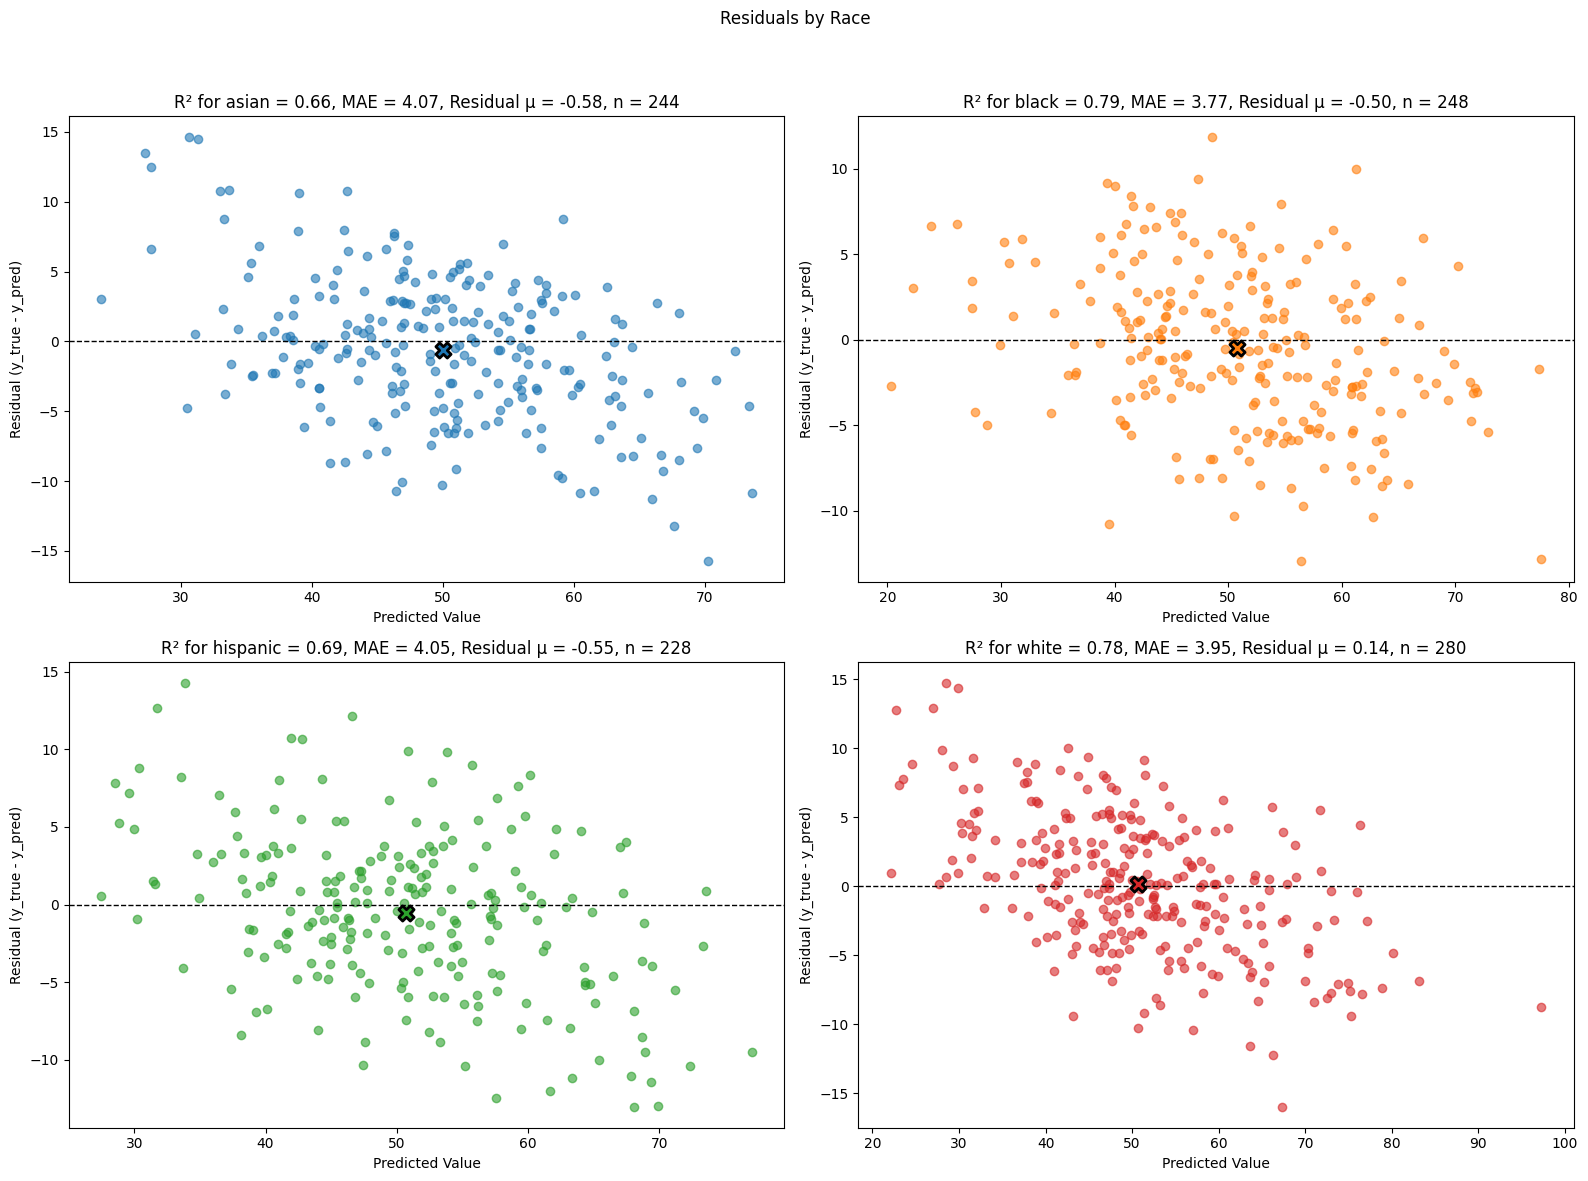

In [27]:
eqb.eq_plot_residuals_by_group(
    data=sliced_data_2,
    title="Residuals by Race",
    filename="residuals_by_race",
    subplots=True,
    # group="black",
    color_by_group=True,
    figsize=(8, 6),
    # group="black",
    show_centroids=True,
    save_path="./images",
    # exclude_groups="white",
    show_grid=False,
)